In [ ]:
import os
import zipfile
from tqdm import tqdm


zip_file_name = 'sentinel2-munich480.zip'


target_directory = '/content/sentinel2-munich480'


os.makedirs(target_directory, exist_ok=True)


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting", unit=" files", ncols=100):
        zip_ref.extract(file_info, target_directory)


Extracting: 100%|███████████████████████████████████| 2298627/2298627 [14:58<00:00, 2557.61 files/s]


In [ ]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-15d297256f94>:16: DeprecationWarning: Please use `maximum_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter1d


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Configuration and Hyperparameters

root_path = '/content/sentinel2-munich480/munich480'
result_path = '/content'
resume_path = '/content/drive/MyDrive/UNET OUTPUT/best_model.pth'
result_train = 'train_results.txt'
result_validation = 'validation_results.txt'
no_of_classes = 18
workers = 8
batch_size = 2
h = w = 7
n_classes = 18
LABEL_FILENAME = "y.tif"
best_test_acc = 0
loss = 'ndvi'
ottimizzatore = 'sgd'
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.9
loss_weights = 'store_true'
ignore_index = 0
test_only = False
sample_duration = 30
n_epochs = 30

num_folds = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings("ignore")


In [ ]:
def save(path, model, optimizer, **kwargs):
    model_state = None
    optimizer_state = None
    if model is not None:
        model_state = model.state_dict()
    if optimizer is not None:
        optimizer_state = optimizer.state_dict()
    torch.save(
        dict(model_state=model_state,
             optimizer_state=optimizer_state,
             **kwargs),
        path
    )


def resume(path, model, optimizer):
    if torch.cuda.is_available():
        snapshot = torch.load(path)
    else:
        snapshot = torch.load(path, map_location="cpu")
    print("Loaded snapshot from", path)

    model_state = snapshot.pop('model_state', snapshot)
    optimizer_state = snapshot.pop('optimizer_state', None)

    if model is not None and model_state is not None:
        print("loading model...")
        model.load_state_dict(model_state)

    if optimizer is not None and optimizer_state is not None:
        optimizer.load_state_dict(optimizer_state)
    return snapshot

In [ ]:
LABEL_FILENAME = "y.tif"
class SentinelDataset(torch.utils.data.Dataset):


    def __init__(self, root_dir, seqlength=30, tileids=None):
        self.root_dir = root_dir
        self.name = os.path.basename(root_dir)
        self.data_dirs = [d for d in os.listdir(self.root_dir) if d.startswith("data")]
        self.seqlength = seqlength
        self.munich_format = None
        self.src_labels = None
        self.dst_labels = None
        self.unique_labels = np.array([], dtype=float)

        self.b8_index = 3
        self.b4_index = 2

        stats = dict(
            rejected_nopath=0,
            rejected_length=0,
            total_samples=0)

        # statistics
        self.samples = list()

        self.ndates = list()

        dirs = []
        if tileids is None:

            for d in self.data_dirs:
                dirs_name = os.listdir(os.path.join(self.root_dir, d))
                dirs_path = [os.path.join(self.root_dir, d, f) for f in dirs_name]
                dirs.extend(dirs_path)
        else:

            with open(os.path.join(self.root_dir, tileids), 'r') as f:
                files = [el.replace("\n", "") for el in f.readlines()]
            for d in self.data_dirs:
                dirs_path = [os.path.join(self.root_dir, d, f) for f in files]
                dirs.extend(dirs_path)

        self.classids, self.classes = self.read_classes(os.path.join(self.root_dir, "classes.txt"))

        for path in dirs:
            if not os.path.exists(path):
                stats["rejected_nopath"] += 1
                continue
            if not os.path.exists(os.path.join(path, LABEL_FILENAME)):
                stats["rejected_nopath"] += 1
                continue

            ndates = len(get_dates(path))

            if ndates < self.seqlength:
                stats["rejected_length"] += 1
                continue

            stats["total_samples"] += 1
            self.samples.append(path)
            self.ndates.append(ndates)

        print_stats(stats)

    def read_classes(self, csv):
        with open(csv, 'r') as f:
            classes = f.readlines()

        ids = list()
        names = list()
        for row in classes:
            row = row.replace("\n", "")
            if '|' in row:
                id, cl = row.split('|')
                ids.append(int(id))
                names.append(cl)

        return ids, names

    def get_image_h_w(self):
        label, profile = read(os.path.join(self.samples[0], LABEL_FILENAME))
        return label.shape[-2], label.shape[-1]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):


        path = self.samples[idx]
        if path.endswith(os.sep):
            path = path[:-1]
        patch_id = os.path.basename(path)

        label, profile = read(os.path.join(path, LABEL_FILENAME))

        profile["name"] = self.samples[idx]

        # unique dates sorted ascending
        dates = get_dates(path, n=self.seqlength)

        x10 = list()
        x20 = list()
        x60 = list()

        for date in dates:
            if self.munich_format is None:
                self.munich_format = os.path.exists(os.path.join(path, date + "_10m.tif"))
                if self.munich_format:
                    self.b8_index = 3
                    self.b4_index = 2
                else:
                    self.b8_index = 6
                    self.b4_index = 2
            if self.munich_format:
                x10.append(read(os.path.join(path, date + "_10m.tif"))[0])
                x20.append(read(os.path.join(path, date + "_20m.tif"))[0])
                x60.append(read(os.path.join(path, date + "_60m.tif"))[0])
            else:
                x10.append(read(os.path.join(path, date + ".tif"))[0])

        x10 = np.array(x10) * 1e-4
        if self.munich_format:
            x20 = np.array(x20) * 1e-4
            x60 = np.array(x60) * 1e-4

        # replace stored ids with index in classes csv
        label = label[0]
        self.unique_labels = np.unique(np.concatenate([label.flatten(), self.unique_labels]))
        new = np.zeros(label.shape, np.int)
        for cl, i in zip(self.classids, range(len(self.classids))):
            new[label == cl] = i

        label = new

        label = torch.from_numpy(label)
        x10 = torch.from_numpy(x10)
        if self.munich_format:
            x20 = torch.from_numpy(x20)
            x60 = torch.from_numpy(x60)

            x20 = F.interpolate(x20, size=x10.shape[2:4])
            x60 = F.interpolate(x60, size=x10.shape[2:4])

            x = torch.cat((x10, x20, x60), 1)
        else:
            x = x10

        x = x.permute(1, 0, 2, 3)

        x = x.float()
        label = label.long()

        target_ndvi = get_all_signatures(x, label, len(self.classids), self.b4_index, self.b8_index)

        return x, label, target_ndvi.float(), dates, patch_id


def get_all_signatures(inp, target, num_cls, b4_index, b8_index):

    c, t, h, w = inp.shape
    output_ndvi = np.zeros((t, h, w), dtype=np.float)


    for cls_index_ in range(0, num_cls):
        pts = (target == cls_index_).numpy()
        all_ndvi_x_cls = []
        for row, yr in enumerate(pts):
            for col, xc in enumerate(yr):
                if xc:
                    b8 = inp[b8_index, :, row, col]
                    b4 = inp[b4_index, :, row, col]
                    ndvi = (b8 - b4) / (b8 + b4)
                    ndvi = np.nan_to_num(ndvi.numpy())
                    all_ndvi_x_cls.append(ndvi)
        mean_ndvi = np.zeros((t,), dtype=float)
        if len(all_ndvi_x_cls) > 1:
            mean_ndvi = np.mean(all_ndvi_x_cls, axis=0)
        if len(all_ndvi_x_cls) == 1:
            mean_ndvi = all_ndvi_x_cls[0]
        mmax_ndvi = __max_filter1d_valid(mean_ndvi, 5)


        output_ndvi[:, pts] = mmax_ndvi.reshape(t, 1)
    return torch.from_numpy(output_ndvi).float()


def __max_filter1d_valid(a, w):
    b = a.clip(min=0)
    return maximum_filter1d(b, size=w)


def read(file):
    with rasterio.open(file) as src:
        return src.read(), src.profile


def get_dates(path, n=None):

    files = os.listdir(path)
    dates = list()
    for f in files:
        f = f.split("_")[0]
        if len(f) == 8:
            dates.append(f)

    dates = set(dates)

    if n is not None:
        dates = random.sample(dates, n)

    dates = list(dates)
    dates.sort()
    return dates


def print_stats(stats):
    print_lst = list()
    for k, v in zip(stats.keys(), stats.values()):
        print_lst.append("{}:{}".format(k, v))
    print('\n', ", ".join(print_lst))


In [ ]:
print("Starting loading Dataset...")

traindataset = SentinelDataset(root_path, tileids="tileids/train_fold0.tileids", seqlength=sample_duration)
traindataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=batch_size, shuffle=True, num_workers=workers)
# How to iterate on a dataloader
for iteration, data in enumerate(traindataloader):
    input, target, target_ndvi, _, _ = data
    print('input temporal series with 30 images of size 13x48x48:', input.shape)
    print('target segmentation image (batchx48x48):', target.shape)
    print('target_ndvi containing 30 channels of size 48x48:', target_ndvi.shape)
    break

# Load test set
testdataset = SentinelDataset(root_path, tileids="tileids/test_fold0.tileids", seqlength=sample_duration)
testdataloader = torch.utils.data.DataLoader(
    testdataset, batch_size=batch_size, shuffle=False, num_workers=workers)
# Load validation set
validationdataset = SentinelDataset(root_path, tileids="tileids/eval.tileids", seqlength=sample_duration)
validationdataloader = torch.utils.data.DataLoader(
    validationdataset, batch_size=batch_size, shuffle=False, num_workers=workers)

numclasses = len(traindataset.classes)
labels = list(range(numclasses))

Starting loading Dataset...

 rejected_nopath:3059, rejected_length:4778, total_samples:5231
input temporal series with 30 images of size 13x48x48: torch.Size([2, 13, 30, 48, 48])
target segmentation image (batchx48x48): torch.Size([2, 48, 48])
target_ndvi containing 30 channels of size 48x48: torch.Size([2, 30, 48, 48])

 rejected_nopath:890, rejected_length:1395, total_samples:1747

 rejected_nopath:806, rejected_length:1441, total_samples:1641



 rejected_nopath:1, rejected_length:13345, total_samples:15169


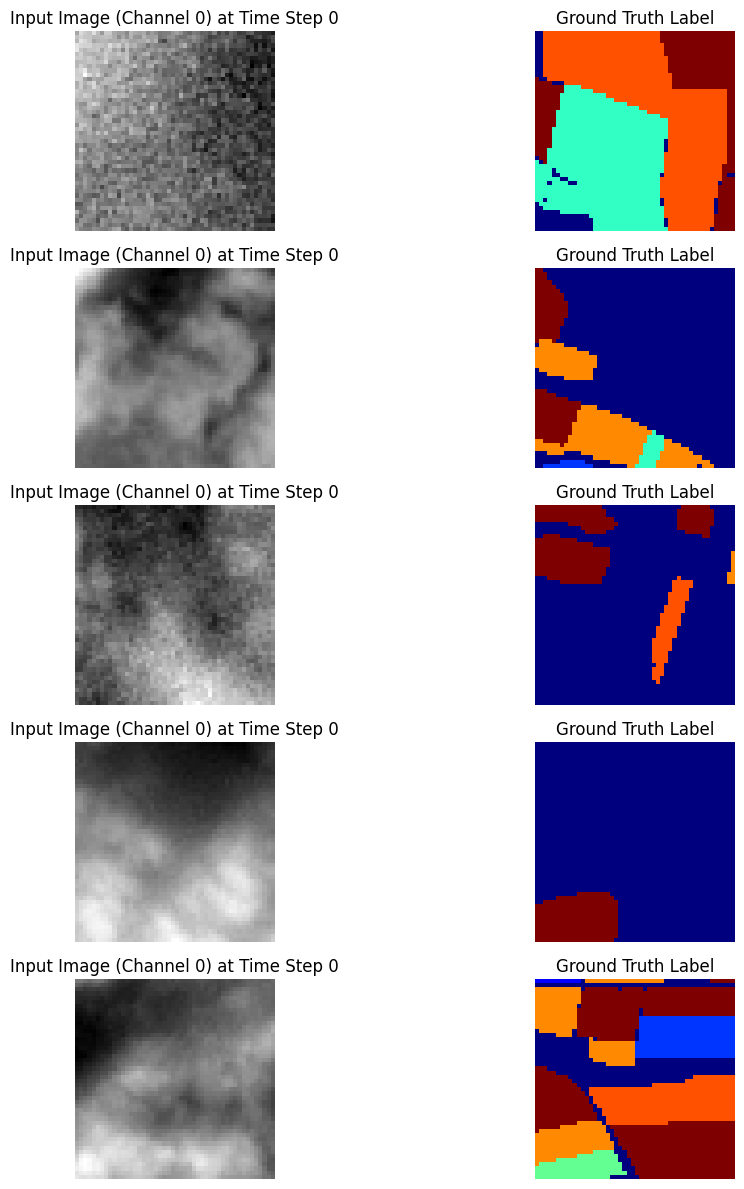

In [ ]:
import matplotlib.pyplot as plt


root_path = '/content/sentinel2-munich480/munich480'
sample_duration = 30
dataset = SentinelDataset(root_path, seqlength=sample_duration)


num_images_to_visualize = 5


time_step_to_visualize = 0
channel_to_visualize = 0


fig, axes = plt.subplots(num_images_to_visualize, 2, figsize=(12, 12))

for i in range(num_images_to_visualize):

    sample_index = i
    sample = dataset[sample_index]


    input_image = sample[0][channel_to_visualize, time_step_to_visualize]
    label = sample[1]

    # Plot the input image
    axes[i, 0].imshow(input_image.numpy(), cmap='gray')
    axes[i, 0].set_title(f'Input Image (Channel {channel_to_visualize}) at Time Step {time_step_to_visualize}')
    axes[i, 0].axis('off')

    # Plot the label image
    axes[i, 1].imshow(label.numpy(), cmap='jet')
    axes[i, 1].set_title('Ground Truth Label')
    axes[i, 1].axis('off')


plt.tight_layout()
plt.show()



 rejected_nopath:1, rejected_length:13345, total_samples:15169


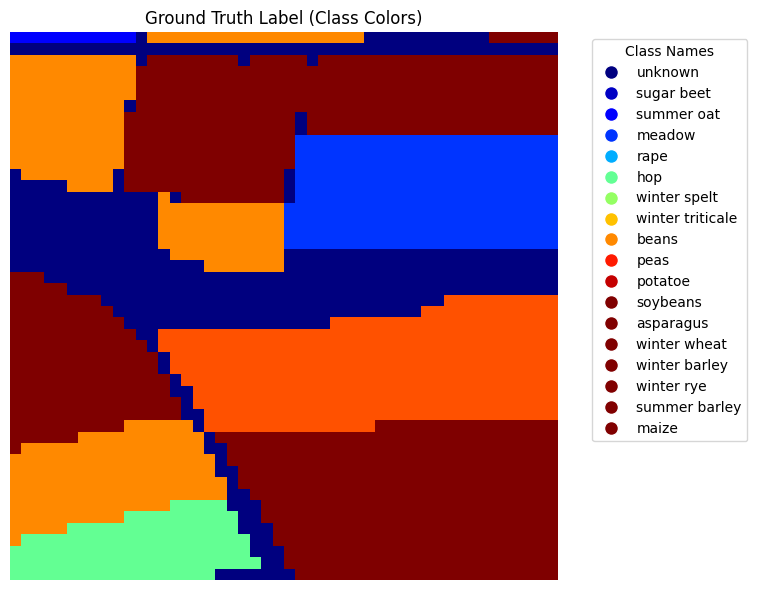

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


root_path = '/content/sentinel2-munich480/munich480'
sample_duration = 30
dataset = SentinelDataset(root_path, seqlength=sample_duration)


sample_index = 4
sample = dataset[sample_index]


label = sample[1]


class_ids, class_names = dataset.classids, dataset.classes


cmap = plt.get_cmap('jet', len(class_ids))


plt.figure(figsize=(8, 6))
plt.imshow(cmap(label.numpy()))
plt.title('Ground Truth Label (Class Colors)')
plt.axis('off')


legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=name,
                              markersize=10, markerfacecolor=cmap(class_ids[i])) for i, name in enumerate(class_names)]
plt.legend(handles=legend_handles, title='Class Names', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


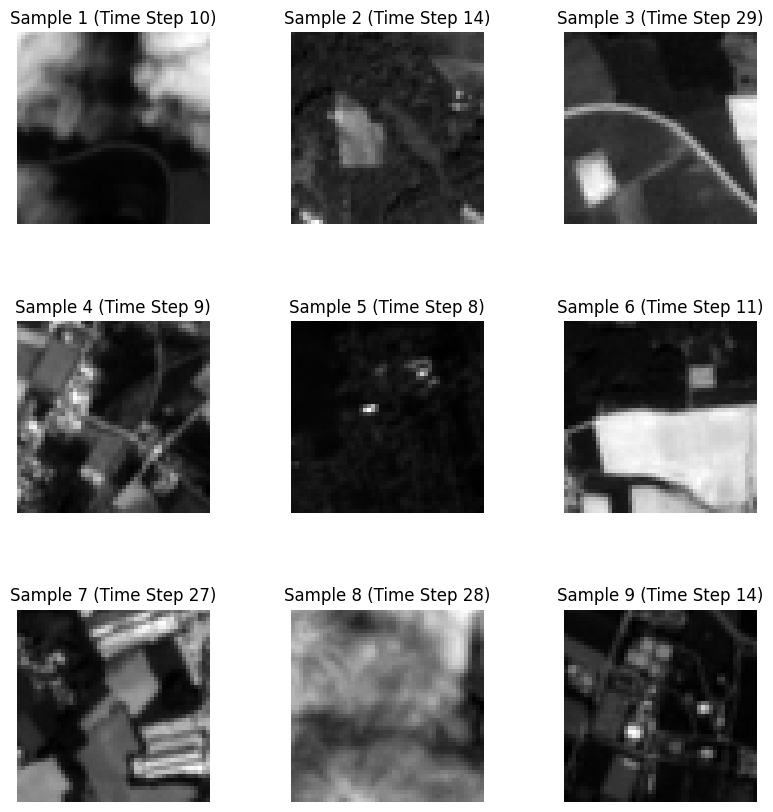

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


num_samples_to_display = 9


fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)


random_indices = np.random.choice(len(dataset), num_samples_to_display, replace=False)

for i, idx in enumerate(random_indices):

    sample = dataset[idx]


    input_images = sample[0]
    label = sample[1]


    random_time_step = np.random.randint(input_images.shape[1])

    # Plot the input image at the selected time step
    input_image = input_images[:, random_time_step]
    axes[i // 3, i % 3].imshow(input_image[0].numpy(), cmap='gray')
    axes[i // 3, i % 3].set_title(f'Sample {i + 1} (Time Step {random_time_step})')
    axes[i // 3, i % 3].axis('off')

# Display the random samples
plt.show()


In [ ]:
class ProgressBar(object):
    DEFAULT = 'Progress: %(bar)s %(percent)3d%%'
    FULL = '%(bar)s %(current)d/%(total)d (%(percent)3d%%) %(remaining)d to go'

    def __init__(self, total, width=40, fmt=DEFAULT, symbol='=',
                 output=sys.stderr):
        assert len(symbol) == 1

        self.total = total
        self.width = width
        self.symbol = symbol
        self.output = output
        self.fmt = re.sub(r'(?P<name>%\(.+?\))d',
            r'\g<name>%dd' % len(str(total)), fmt)

        self.current = 0

    def __call__(self):
        percent = self.current / float(self.total)
        size = int(self.width * percent)
        remaining = self.total - self.current
        bar = '[' + self.symbol * size + ' ' * (self.width - size) + ']'

        args = {
            'total': self.total,
            'bar': bar,
            'current': self.current,
            'percent': percent * 100,
            'remaining': remaining
        }
        print('\r' + self.fmt % args, file=self.output, end='')

    def done(self):
        self.current = self.total
        self()
        print('', file=self.output)


In [ ]:
class SegmentationLosses(object):
    def __init__(self, weight=None, size_average=True, batch_average=True, ignore_index=-100, cuda=False):
        self.ignore_index = ignore_index
        self.weight = weight
        self.size_average = size_average
        self.batch_average = batch_average
        self.cuda = cuda
        self.criterion_xent = None
        self.criterion_mse = None
        self.beta = 0.9999

    def build_loss(self, mode='ce'):
        loss_func = None
        """Choices: ['ce' | 'focal' | 'ndvi' | 'batch']"""
        if mode == 'ce':
            self.criterion_xent = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            loss_func = self.cross_entropy_loss
        elif mode == 'focal':
            self.criterion_xent = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            loss_func = self.focal_loss
        elif mode == 'ndvi':
            self.criterion_xent = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            self.criterion_mse = nn.MSELoss()

            loss_func = self.ndvi_loss
        elif mode == 'batch':

            self.criterion_xent = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            loss_func = self.class_balanced_loss
        else:
            raise NotImplementedError

        if self.cuda:
            self.criterion_xent = self.criterion_xent.cuda()
            if self.criterion_mse is not None:
                self.criterion_mse = self.criterion_mse.cuda()

        return loss_func

    def cross_entropy_loss(self, logit, target):
        n, c, h, w = logit.size()

        loss = self.criterion_xent(logit, target.long())

        if self.batch_average:
            loss /= n

        return loss

    def focal_loss(self, logit, target, gamma=2, alpha=0.5):
        n, c, h, w = logit.size()

        logpt = -self.criterion_xent(logit, target.long())
        pt = torch.exp(logpt)
        if alpha is not None:
            logpt *= alpha
        loss = -((1 - pt) ** gamma) * logpt

        if self.batch_average:
            loss /= n

        return loss

    def ndvi_loss(self, ndvi_features, logit, target_cls, ndvi_target, samples_per_cls, weight_mse=1.0):
        n, c, h, w = logit.size()
        assert (not torch.isnan(ndvi_target).any())

        # Effective Number of Samples (ENS)
        if not samples_per_cls == None:
            assert (samples_per_cls.shape[0] == c)
            weights = (1.0 - self.beta) / (1.0 - torch.pow(self.beta, samples_per_cls.float()))
            weights[weights == float('inf')] = 0
            weights = weights / torch.sum(weights) * c  # wights in the range [0, c]
            self.criterion_xent.weight = weights

        loss_xent = self.criterion_xent(logit, target_cls.long())
        loss_mse = self.criterion_mse(ndvi_features, ndvi_target)
        loss_mse *= weight_mse
        loss = loss_xent + loss_mse

        if self.batch_average:
            loss /= n

        return loss

    def class_balanced_loss(self, logit, target, samples_per_cls, weight_type='ENS'):

        n, c, h, w = logit.size()


        assert(samples_per_cls.shape[0] == c)


        if weight_type == 'ENS':

            weights = (1.0 - self.beta) / (1.0 - torch.pow(self.beta, samples_per_cls.float()))
            weights[weights == float('inf')] = 0
        elif weight_type == 'ISNS':

            weights = 1.0 / torch.sqrt(torch.tensor([2, 1000, 1, 20000, 500]).float())
        else:
            weights = 1.0 / torch.tensor([2, 1000, 1, 20000, 500]).float()

        weights = weights / torch.sum(weights) * c

        self.criterion_xent.weight = weights
        loss = self.criterion_xent(logit, target.long())

        if self.batch_average:
            loss /= n

        return loss



In [ ]:
class Meter(object):


    def reset(self):
        pass

    def add(self, value):

        pass

    def value(self):
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan


In [ ]:
class BaseObject(nn.Module):

    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
            return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass

class ConfusionMatrix(Metric):

    def __init__(self, labels, ignore_class=None, **kwargs):
        super().__init__(**kwargs)
        self.ignore_class = ignore_class
        self.labels = labels
        self.n_classes = len(self.labels)
        if self.ignore_class is not None:
            self.matrix = np.zeros((self.n_classes-1, self.n_classes-1))
        else:
            self.matrix = np.zeros((self.n_classes, self.n_classes))

    def get_labels(self):
        if self.ignore_class is not None:
            return np.delete(self.labels, self.ignore_class)
        return self.labels

    def forward(self, y_pr, y_gt):
        # sklearn.metrics
        pred = y_pr.view(-1).cpu().detach().tolist()
        targ = y_gt.view(-1).cpu().detach().tolist()

        matrix = confusion_matrix(targ, pred, labels=self.labels)

        if self.ignore_class is not None:
            matrix = np.delete(matrix, self.ignore_class, 0)
            matrix = np.delete(matrix, self.ignore_class, 1)

        self.matrix = np.add(self.matrix, matrix)

        results_vec = {"labels": self.get_labels(), "confusion matrix": self.matrix}

        total = np.sum(self.matrix)
        true_positive = np.diag(self.matrix)
        sum_rows = np.sum(self.matrix, axis=0)
        sum_cols = np.sum(self.matrix, axis=1)
        false_positive = sum_rows - true_positive
        false_negative = sum_cols - true_positive
        # calculate accuracy
        overall_accuracy = np.sum(true_positive) / total
        results_scalar = {"OA": overall_accuracy}

        # calculate Cohen Kappa
        p0 = np.sum(true_positive) / total
        pc = np.sum(sum_rows * sum_cols) / total ** 2
        kappa = (p0 - pc) / (1 - pc)
        results_scalar["Kappa"] = kappa

        # Per class recall, prec and F1
        recall = true_positive / (sum_cols + 1e-12)
        results_vec["R"] = recall
        precision = true_positive / (sum_rows + 1e-12)
        results_vec["P"] = precision
        f1 = (2 * precision * recall) / ((precision + recall) + 1e-12)
        results_vec["F1"] = f1


        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
            results_vec["IoU"] = iou
            results_scalar["mIoU"] = np.nanmean(iou)

        # Per class accuracy
        cl_acc = true_positive / (sum_cols + 1e-12)
        results_vec["Acc"] = cl_acc

        # weighted measures
        prob_c = sum_rows / total
        prob_r = sum_cols / total
        recall_weighted = np.inner(recall, prob_r)
        results_scalar["wR"] = recall_weighted
        precision_weighted = np.inner(precision, prob_r)
        results_scalar["wP"] = precision_weighted
        f1_weighted = 2 * (recall_weighted * precision_weighted) / (recall_weighted + precision_weighted)
        results_scalar["wF1"] = f1_weighted
        random_accuracy = np.inner(prob_c, prob_r)
        results_scalar["RAcc"] = random_accuracy

        return results_vec, results_scalar

In [ ]:
def write_signatures(fcn, target, output, target_ndvi, out_ndvi, dates, patch_id, set_name):

    nb, nt, h, w = target_ndvi.shape
    assert(len(dates) == nt)
    assert(len(dates[0]) == nb)

    # winner class for each pixel
    winners = torch.softmax(output, dim=1).argmax(dim=1)

    weight = fcn.conv5out.weight

    for idx, patch_name in enumerate(patch_id):
        # print('patch_name:', patch_name)
        with open(os.path.join(result_path, set_name + '_patch_' + patch_name + ".txt"), 'w') as f:
            f.write('class, output, type_ndvi, x, y, ')
            f.write(', '.join(map(str, [e[idx] for e in dates])))
            f.write("\n")
            for y in range(0, h):
                for x in range(0, w):
                    target_idx = target[idx, y, x].item()
                    output_idx = winners[idx, y, x].item()
                    f.write('%d, %d, target, %d, %d, ' % (target_idx, output_idx, x, y))
                    f.write(', '.join(map(str, target_ndvi[idx, :, y, x].data.tolist())))
                    f.write("\n")
                    f.write('%d, %d, predic, %d, %d, ' % (target_idx, output_idx, x, y))
                    f.write(', '.join(map(str, out_ndvi[idx, :, y, x].data.tolist())))
                    f.write("\n")
                    f.write('%d, %d, cls_ai, output, %d, %d, ' % (target_idx, output_idx, x, y))
                    cai = class_activations(out_ndvi, weight, target_idx, idx, y, x)
                    f.write(', '.join(map(str, cai.data.tolist())))
                    f.write("\n")


def get_all_signatures(inp, target, num_cls, b4_index, b8_index):

    c, t, h, w = inp.shape
    output_ndvi = np.zeros((t, h, w), dtype=np.float)

    for cls_index_ in range(0, num_cls):
        pts = (target == cls_index_).numpy()
        all_ndvi_x_cls = []
        for row, yr in enumerate(pts):
            for col, xc in enumerate(yr):
                if xc:

                    b8 = inp[b8_index, :, row, col]
                    b4 = inp[b4_index, :, row, col]
                    ndvi = (b8 - b4) / (b8 + b4)
                    ndvi = np.nan_to_num(ndvi.numpy())
                    all_ndvi_x_cls.append(ndvi)
        mean_ndvi = np.zeros((t,), dtype=float)
        if len(all_ndvi_x_cls) > 1:
            mean_ndvi = np.mean(all_ndvi_x_cls, axis=0)
        if len(all_ndvi_x_cls) == 1:
            mean_ndvi = all_ndvi_x_cls[0]
        mmax_ndvi = __max_filter1d_valid(mean_ndvi, 5)

        output_ndvi[:, pts] = mmax_ndvi.reshape(t, 1)
    # plt.show()
    return torch.from_numpy(output_ndvi).float()

In [ ]:
def adjust_classes_weights(cur_epoch, curr_iter, num_iter_x_epoch, tot_epochs, start_w, descending=True):
    current_iter = curr_iter + cur_epoch * num_iter_x_epoch
    max_iter = tot_epochs * num_iter_x_epoch
    a = 1 - current_iter / (max_iter)
    if not descending:
        a = 1 - a

    w = a * start_w + 1 - a
    return w
def adjust_classes_weights(cur_epoch, curr_iter, num_iter_x_epoch, tot_epochs, start_w, descending=True):
    current_iter = curr_iter + cur_epoch * num_iter_x_epoch
    max_iter = tot_epochs * num_iter_x_epoch

    a = 1 - current_iter / (max_iter)
    if not descending:
        a = 1 - a

    w = a * start_w + 1 - a
    return w


def adjust_learning_rate(cur_epoch, curr_iter, num_iter_x_epoch, tot_epochs, start_lr, lr_decay='cos'):
    current_iter = curr_iter + cur_epoch * num_iter_x_epoch
    max_iter = tot_epochs * num_iter_x_epoch

    if lr_decay == 'cos':
        lr = start_lr * (1 + cos(pi * (current_iter) / (max_iter))) / 2
    elif lr_decay == 'linear':
        lr = start_lr * (1 - (current_iter) / (max_iter))
    else:
        raise ValueError('Unknown lr mode {}'.format(lr_decay))

    return lr



def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _remove_index(np_matrix, ignore_index=-100):
    if ignore_index == -100:
        return np_matrix
    else:
        m = np.delete(np_matrix, ignore_index, 0)
        m = np.delete(m, ignore_index, 1)
        return m


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, labels, threshold=None, ignore_channels=None):

    # Dimensions check
    assert pr.size(0) == gt.size(0), \
        'number of targets and predicted outputs do not match'
    assert pr.dim() == gt.dim(), \
        "predictions and targets must be of dimension (N, H, W)"

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    # sklearn.metrics
    pr1d = pr.view(-1).cpu().detach().numpy()
    gt1d = gt.view(-1).cpu().detach().numpy()
    score = jaccard_score(gt1d, pr1d, labels=labels, average=None)

    return score


def f_score(pr, gt, labels, threshold=None, ignore_channels=None):


    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    # sklearn.metrics
    pr1d = pr.view(-1).cpu().detach().numpy()
    gt1d = gt.view(-1).cpu().detach().numpy()
    score = f1_score(gt1d, pr1d, labels=labels, average=None)


    return score


def accuracy(pr, gt, labels, threshold=None, ignore_channels=None, ignore_index=-100):

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    # sklearn.metrics
    pr1d = pr.view(-1).cpu().detach().numpy()
    gt1d = gt.view(-1).cpu().detach().numpy()

    matrix = confusion_matrix(gt1d, pr1d, labels=labels)
    matrix = _remove_index(matrix, ignore_index)
    diagonal = matrix.diagonal()
    score_per_class = np.nan_to_num(diagonal / matrix.sum(axis=1))

    score = diagonal.sum() / matrix.sum()


    return score_per_class, score


def precision(pr, gt, labels, threshold=None, ignore_channels=None):

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    # sklearn.metrics
    pr1d = pr.view(-1).cpu().detach().numpy()
    gt1d = gt.view(-1).cpu().detach().numpy()
    score = precision_score(gt1d, pr1d, labels=labels, average=None)

    return score


def recall(pr, gt, labels, threshold=None, ignore_channels=None):

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    # sklearn.metrics
    pr1d = pr.view(-1).cpu().detach().numpy()
    gt1d = gt.view(-1).cpu().detach().numpy()
    score = recall_score(gt1d, pr1d, labels=labels, average=None)  # per class measure

    return score


In [ ]:
import numpy

In [ ]:
def compute_train_weights(train_loader):
    beta = 0.9
    samples_per_cls = torch.zeros(n_classes)
    for batch_idx, data in enumerate(train_loader):
        inputs, targets, _, _, _ = data
        for cls in range(n_classes):
            samples_per_cls[cls] += torch.sum(targets == cls)
    max_occ = torch.max(samples_per_cls)
    weights = torch.FloatTensor(max_occ / samples_per_cls)

    if torch.cuda.is_available():
        weights = weights.cuda()

    return weights

def train_epoch(dataloader, network, optimizer, loss, ep, loss_cls, cls_weights=None):
    num_processed_samples = 0
    num_train_samples = len(dataloader.dataset)
    labels = list(range(numclasses))

    conf_mat_metrics = ConfusionMatrix(labels, ignore_class=ignore_index)
    num_cls = 18
    batch_size = 18
    labels = list(range(num_cls))
    conf_mat = ConfusionMatrix(labels, ignore_class=0)

    for e in range(5):
        target = torch.randint(num_cls, (batch_size,))
        output = torch.rand(batch_size, num_cls)
        pred = torch.argmax(output, dim=1)
        metrics_v, metrics_s = conf_mat(pred, target)
        for k, v in metrics_v.items():
            print(k, v)
        for k, v in metrics_s.items():
            print(k, v)
        print()
    loss_measure = AverageValueMeter()
    am = AverageValueMeter()
    am.add(numpy.array([1, 0.5, 0.2, 0.1, 0.8]))
    mean, std = am.value()
    print(mean, std, am.sum)

    am.add(numpy.array([0.5, 0.5, 0.5, 0.5, 0.5]))
    mean, std = am.value()
    print(mean, std, am.sum)
    var_learning_rate = learning_rate
    for iteration, data in enumerate(dataloader):

        if optimizer == 'sgd':
            var_learning_rate = adjust_learning_rate(ep, iteration,  len(dataloader),
                                      n_epochs, learning_rate, lr_decay='cos')
            for param_group in optimizer.param_groups:
                param_group['lr'] = var_learning_rate
        if cls_weights is not None:
            loss_cls.weight = adjust_classes_weights(ep, iteration, len(dataloader),
                                      n_epochs, cls_weights, descending=False)

        optimizer.zero_grad()

        input, target, target_ndvi, _, _ = data
        num_processed_samples += len(input)
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
            target_ndvi = target_ndvi.cuda()

        if loss == 'batch':
            output = network.forward(input)
            samples_per_cls = torch.stack([(target == x_u).sum() for x_u in range(n_classes)])
            l = loss(output, target, samples_per_cls)
        elif loss == 'ndvi':
            out_ndvi, output = network.forward(input)
            samples_per_cls = None
            if loss_weights:
                samples_per_cls = torch.stack([(target == x_u).sum() for x_u in range(n_classes)])
            l = loss(out_ndvi, output, target, target_ndvi, samples_per_cls, weight_mse=1.0)
        else:
            output = network.forward(input)
            l = loss(output, target)

        l.backward()
        optimizer.step()

        with torch.no_grad():
            pred = torch.argmax(output, dim=1).squeeze(1)

            metrics_v, metrics_scalar = conf_mat_metrics(pred, target)
            str_metrics = ''.join(['%s| %f | ' % (key, value) for (key, value) in metrics_scalar.items()])
            loss_measure.add(l.item())
            str_metrics += 'loss| %f | ' % loss_measure.mean

            train_info = 'Train on | {} | Epoch| {} | [{}/{} ({:.0f}%)] | lr| {:.5f} | {}    '.format(
                dataloader.dataset.name, ep, num_processed_samples, num_train_samples,
                100. * (iteration + 1) / len(dataloader), var_learning_rate, str_metrics)
            sys.stdout.write('\r' + train_info)

    print()
    with open(os.path.join(result_path, result_train), 'a+') as f:
        f.write(train_info + '\n')


def test_epoch(dataloader, network, loss):
    num_processed_samples = 0
    num_test_samples = len(dataloader.dataset)
    labels = list(range(numclasses))
    conf_mat_metrics = ConfusionMatrix(labels, ignore_class=ignore_index)
    num_cls = 18
    batch_size = 18
    labels = list(range(num_cls))
    conf_mat = ConfusionMatrix(labels, ignore_class=0)

    for e in range(5):
        target = torch.randint(num_cls, (batch_size,))
        output = torch.rand(batch_size, num_cls)
        pred = torch.argmax(output, dim=1)
        metrics_v, metrics_s = conf_mat(pred, target)
        for k, v in metrics_v.items():
            print(k, v)
        for k, v in metrics_s.items():
            print(k, v)
        print()
    loss_measure = AverageValueMeter()
    am = AverageValueMeter()
    am.add(numpy.array([1, 0.5, 0.2, 0.1, 0.8]))
    mean, std = am.value()
    print(mean, std, am.sum)

    am.add(numpy.array([0.5, 0.5, 0.5, 0.5, 0.5]))
    mean, std = am.value()
    print(mean, std, am.sum)

    with torch.no_grad():
        for iteration, data in enumerate(dataloader):

            input, target, target_ndvi, _, _ = data
            num_processed_samples += len(input)
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()
                target_ndvi = target_ndvi.cuda()

            if loss == 'batch':
                output = network.forward(input)
                samples_per_cls = torch.stack([(target == x_u).sum() for x_u in range(n_classes)])
                l = loss(output, target, samples_per_cls)
            elif loss == 'ndvi':
                out_ndvi, output = network.forward(input)
                samples_per_cls = None
                if loss_weights:
                    samples_per_cls = torch.stack([(target == x_u).sum() for x_u in range(n_classes)])
                l = loss(out_ndvi, output, target, target_ndvi, samples_per_cls)
            else:
                output = network.forward(input)
                l = loss(output, target)

            pred = torch.argmax(output, dim=1).squeeze(1)
            metrics_v, metrics_scalar = conf_mat_metrics(pred, target)
            str_metrics = ''.join(['%s| %f | ' % (key, value) for (key, value) in metrics_scalar.items()])
            loss_measure.add(l.item())
            str_metrics += 'loss| %f | ' % loss_measure.mean
            test_info = 'Test on | {} | Epoch | {} | [{}/{} ({:.0f}%)] | {}  '.format(
                dataloader.dataset.name, epoch, num_processed_samples,
                num_test_samples, 100. * (iteration + 1) / len(dataloader),
                str_metrics)
            sys.stdout.write('\r' + test_info)

        is_best = metrics_scalar['OA'] > best_test_acc
        best = '  **best result' if is_best else '         '
        test_info += best

        sys.stdout.write('\r' + test_info + '\n')
        with open(os.path.join(result_path, result_validation), 'a+') as f:
            f.write(test_info + '\n')

        if is_best:
            cls_names = numpy.array(traindataset.classes)[conf_mat_metrics.get_labels()]
            with open(os.path.join(result_path, "per_class_metrics.txt"), 'a+') as f:
                f.write('classes:\n' + numpy.array2string(cls_names) + '\n')
                for k, v in metrics_v.items():
                    f.write(k + '\n')
                    if len(v.shape) == 1:
                        for ki, vi in zip(cls_names, v):
                            f.write("%.2f" % vi + '\t' + ki + '\n')
                    elif len(v.shape) == 2:  # confusion matrix
                        num_gt = numpy.sum(v, axis=1)
                        f.write('\n'.join(
                            [''.join(['{:10}'.format(item) for item in row]) + '  ' + lab + '(%d)' % tot
                             for row, lab, tot in zip(v, cls_names, num_gt)]))
                        f.write('\n')

        return metrics_scalar['OA']  # test_acc


def test_only(dataloader, network, loss, epoch, set_name):
    num_processed_samples = 0
    num_test_samples = len(dataloader.dataset)
    labels = list(range(numclasses))
    conf_mat_metrics = ConfusionMatrix(labels, ignore_class=ignore_index)
    num_cls = 18
    batch_size = 18
    labels = list(range(num_cls))
    conf_mat = ConfusionMatrix(labels, ignore_class=0)

    for e in range(5):
        target = torch.randint(num_cls, (batch_size,))
        output = torch.rand(batch_size, num_cls)
        pred = torch.argmax(output, dim=1)
        metrics_v, metrics_s = conf_mat(pred, target)
        for k, v in metrics_v.items():
            print(k, v)
        for k, v in metrics_s.items():
            print(k, v)
        print()
    loss_measure = AverageValueMeter()
    am = AverageValueMeter()
    am.add(numpy.array([1, 0.5, 0.2, 0.1, 0.8]))
    mean, std = am.value()
    print(mean, std, am.sum)

    am.add(numpy.array([0.5, 0.5, 0.5, 0.5, 0.5]))
    mean, std = am.value()
    print(mean, std, am.sum)

    with torch.no_grad():
        for iteration, data in enumerate(dataloader):

            input, target, target_ndvi, dates, patch_id = data

            num_processed_samples += len(input)
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()
                target_ndvi = target_ndvi.cuda()

            if loss == 'batch':
                output = network.forward(input)
                samples_per_cls = torch.stack([(target == x_u).sum() for x_u in range(n_classes)])
                l = loss(output, target, samples_per_cls)
            elif loss == 'ndvi':
                out_ndvi, output = network.forward(input)
                samples_per_cls = None
                if loss_weights:
                    samples_per_cls = torch.stack([(target == x_u).sum() for x_u in range(n_classes)])
                l = loss(out_ndvi, output, target, target_ndvi, samples_per_cls)
                if iteration % 100 == 0:
                    write_signatures(model.module, target, output, target_ndvi, out_ndvi, dates, patch_id, set_name)
            else:
                output = network.forward(input)
                l = loss(output, target)

            pred = torch.argmax(output, dim=1).squeeze(1)
            metrics_v, metrics_scalar = conf_mat_metrics(pred, target)
            str_metrics = ''.join(['%s| %f | ' % (key, value) for (key, value) in metrics_scalar.items()])
            loss_measure.add(l.item())
            str_metrics += 'loss| %f | ' % loss_measure.mean
            test_info = 'Test on | {} | Epoch | {} | [{}/{} ({:.0f}%)] | {}  '.format(
                dataloader.dataset.name, epoch, num_processed_samples,
                num_test_samples, 100. * (iteration + 1) / len(dataloader),
                str_metrics)
            if ((100. * (iteration + 1))%100 == 0):
                sys.stdout.write('\r' + test_info)


        cls_names = numpy.array(traindataset.classes)[conf_mat_metrics.get_labels()]
        if ((100. * (iteration + 1))%100 == 0):
            sys.stdout.write('\r' + test_info)
        with open(os.path.join(result_path, set_name + "_per_class_metrics.txt"), 'w') as f:
            f.write('classes:\n' + numpy.array2string(cls_names) + '\n')
            sys.stdout.write('classes:\n' + numpy.array2string(cls_names) + '\n')
            for k, v in metrics_v.items():
                sys.stdout.write('\n' + k + '\n')
                f.write('\n' + k + '\n')
                if len(v.shape) == 1:
                    for ki, vi in zip(cls_names, v):
                        sys.stdout.write("%.2f" % vi + '\t' + ki + '\n')
                        f.write("%.2f" % vi + '\t' + ki + '\n')
                elif len(v.shape) == 2:  # confusion matrix
                    num_gt = numpy.sum(v, axis=1)
                    sys.stdout.write('\n'.join(
                        [''.join(['{:10}'.format(item) for item in row]) + '  ' + lab + '(%d)' % tot
                         for row, lab, tot in zip(v, cls_names, num_gt)]))
                    f.write('\n'.join(
                        [''.join(['{:10}'.format(item) for item in row]) + '  ' + lab + '(%d)' % tot
                         for row, lab, tot in zip(v, cls_names, num_gt)]))
                    sys.stdout.write('\n')
                    f.write('\n')

        if loss == 'ndvi':
            print("\nClass Activation Interval saved in:", result_path)

In [ ]:
class UNet(Module):

    def __init__(self, num_channels=13, feat_channels=[48, 256, 256, 512, 1024], residual='conv'):


        super(UNet, self).__init__()

        # Encoder downsamplers
        self.pool1 = MaxPool3d((2, 2, 2))
        self.pool2 = MaxPool3d((2, 2, 2))
        self.pool3 = MaxPool3d((2, 2, 2))
        self.pool4 = MaxPool3d((2, 2, 2))

        # Encoder convolutions
        self.conv_blk1 = Conv3D_Block(num_channels, feat_channels[0], residual=residual)
        self.conv_blk2 = Conv3D_Block(feat_channels[0], feat_channels[1], residual=residual)
        self.conv_blk3 = Conv3D_Block(feat_channels[1], feat_channels[2], residual=residual)
        self.conv_blk4 = Conv3D_Block(feat_channels[2], feat_channels[3], residual=residual)
        self.conv_blk5 = Conv3D_Block(feat_channels[3], feat_channels[4], residual=residual)

        # Decoder convolutions
        self.dec_conv_blk4 = Conv3D_Block(2 * feat_channels[3], feat_channels[3], residual=residual)
        self.dec_conv_blk3 = Conv3D_Block(2 * feat_channels[2], feat_channels[2], residual=residual)
        self.dec_conv_blk2 = Conv3D_Block(2 * feat_channels[1], feat_channels[1], residual=residual)
        self.dec_conv_blk1 = Conv3D_Block(2 * feat_channels[0], feat_channels[0], residual=residual)

        # Decoder upsamplers
        self.deconv_blk4 = Deconv3D_Block(feat_channels[4], feat_channels[3])
        self.deconv_blk3 = Deconv3D_Block(feat_channels[3], feat_channels[2])
        self.deconv_blk2 = Deconv3D_Block(feat_channels[2], feat_channels[1])
        self.deconv_blk1 = Deconv3D_Block(feat_channels[1], feat_channels[0])

        # Final 1*1 Conv Segmentation map
        self.one_conv = Conv3d(feat_channels[0], 1, kernel_size=1, stride=1, padding=0, bias=True)

        num_classes = 18
        self.final_conv = torch.nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0, bias=True)

        # Activation function
        self.sigmoid = Sigmoid()

    def forward(self, x):
        # Encoder part

        x = torch.permute(x, (0,1,3,4,2))
        x = torch.nn.functional.pad(x,(0, 2), mode='constant', value=0.0)
        x = torch.permute(x, (0,1,4,3,2))
        print(x.shape)
        x1 = self.conv_blk1(x)

        x_low1 = self.pool1(x1)
        x2 = self.conv_blk2(x_low1)

        x_low2 = self.pool2(x2)
        x3 = self.conv_blk3(x_low2)

        x_low3 = self.pool3(x3)
        x4 = self.conv_blk4(x_low3)

        x_low4 = self.pool4(x4)
        base = self.conv_blk5(x_low4)

        # Decoder part
        d4 = torch.cat([self.deconv_blk4(base), x4], dim=1)
        d_high4 = self.dec_conv_blk4(d4)

        test2 = self.deconv_blk3(d_high4)

        d3 = torch.cat([test2, x3], dim=1)
        d_high3 = self.dec_conv_blk3(d3)
        d_high3 = Dropout3d(p=0.5)(d_high3)

        d2 = torch.cat([self.deconv_blk2(d_high3), x2], dim=1)
        d_high2 = self.dec_conv_blk2(d2)
        d_high2 = Dropout3d(p=0.5)(d_high2)

        d1 = torch.cat([self.deconv_blk1(d_high2), x1], dim=1)
        d_high1 = self.dec_conv_blk1(d1)

        conv_out = self.one_conv(d_high1)
        conv_out = conv_out.squeeze(1)

        out = self.final_conv(conv_out)
        seg = self.sigmoid(out)

        return seg


class Conv3D_Block(Module):

    def __init__(self, inp_feat, out_feat, kernel=3, stride=1, padding=1, residual=None):

        super(Conv3D_Block, self).__init__()

        self.conv1 = Sequential(
            Conv3d(inp_feat, out_feat, kernel_size=kernel,
                   stride=stride, padding=padding, bias=True),
            BatchNorm3d(out_feat),
            ReLU())

        self.conv2 = Sequential(
            Conv3d(out_feat, out_feat, kernel_size=kernel,
                   stride=stride, padding=padding, bias=True),
            BatchNorm3d(out_feat),
            ReLU())

        self.residual = residual

        if self.residual is not None:
            self.residual_upsampler = Conv3d(inp_feat, out_feat, kernel_size=1, bias=False)

    def forward(self, x):

        res = x

        if not self.residual:
            return self.conv2(self.conv1(x))
        else:
            return self.conv2(self.conv1(x)) + self.residual_upsampler(res)


class Deconv3D_Block(Module):

    def __init__(self, inp_feat, out_feat, kernel=3, stride=2, padding=1):
        super(Deconv3D_Block, self).__init__()

        self.deconv = Sequential(
            ConvTranspose3d(inp_feat, out_feat, kernel_size=(kernel, kernel, kernel),
                            stride=(stride, stride, stride), padding=(padding, padding, padding), output_padding=1, bias=True),
            ReLU())

    def forward(self, x):
        return self.deconv(x)


class ChannelPool3d(AvgPool1d):

    def __init__(self, kernel_size, stride, padding):
        super(ChannelPool3d, self).__init__(kernel_size, stride, padding)
        self.pool_1d = AvgPool1d(self.kernel_size, self.stride, self.padding, self.ceil_mode)

    def forward(self, inp):
        n, c, d, w, h = inp.size()
        inp = inp.view(n, c, d * w * h).permute(0, 2, 1)
        pooled = self.pool_1d(inp)
        c = int(c / self.kernel_size[0])
        return inp.view(n, c, d, w, h)


In [ ]:
def __max_filter1d_valid(a, w):
    b = a.clip(min=0)  # transform negative elements to zero
    return maximum_filter1d(b, size=w)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet().cuda()

cpu


In [ ]:
labels = list(range(numclasses))

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model).cuda()
if ottimizzatore == 'adam':
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)
elif ottimizzatore == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)

# Define Criterion
weights = None
if not (loss == 'batch' or loss == 'ndvi') and loss_weights:
    print('Computing weights per classes...')
    weights = compute_train_weights(traindataloader)
    weights = torch.sqrt(weights)
    print("weights per classes:", weights)

loss_cls = SegmentationLosses(weight=weights, cuda=True, ignore_index=ignore_index)
loss = loss_cls.build_loss(mode='ce')




start_epoch = 0
if resume_path:
    print('trying to resume previous saved model...')
    state = resume(resume_path, model=model, optimizer=optimizer)

    if "epoch" in state.keys():
        start_epoch = state["epoch"]
        best_test_acc = state['best_test_acc']


for epoch in range(start_epoch, n_epochs):
    train_epoch(traindataloader, model, optimizer, loss, epoch, loss_cls, cls_weights=None)
    val_acc = test_epoch(validationdataloader, model, loss)

    is_best = val_acc > best_test_acc
    if is_best:
        epochs_best_acc = epoch
        best_test_acc = val_acc
        if result_path:
            checkpoint_name = os.path.join(result_path, "best_model.pth")
            save(checkpoint_name, model, optimizer,
                epoch=epoch, best_test_acc=best_test_acc)

labels [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
confusion matrix [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
R [0

In [ ]:
file_path = 'train_results.txt'
with open(file_path, 'r') as file:
    print(file.read())


Train on | munich480 | Epoch| 0 | [5231/5231 (100%)] | lr| 0.01000 | OA| 0.287343 | Kappa| 0.006231 | mIoU| 0.027800 | wR| 0.287343 | wP| 0.219856 | wF1| 0.249109 | RAcc| 0.282875 | loss| 1.230114 |     
Train on | munich480 | Epoch| 1 | [5231/5231 (100%)] | lr| 0.01000 | OA| 0.300085 | Kappa| 0.036349 | mIoU| 0.032305 | wR| 0.300085 | wP| 0.209776 | wF1| 0.246933 | RAcc| 0.273684 | loss| 1.222414 |     
Train on | munich480 | Epoch| 2 | [5231/5231 (100%)] | lr| 0.01000 | OA| 0.316129 | Kappa| 0.066961 | mIoU| 0.041578 | wR| 0.316129 | wP| 0.252322 | wF1| 0.280645 | RAcc| 0.267051 | loss| 1.207731 |     
Train on | munich480 | Epoch| 3 | [5231/5231 (100%)] | lr| 0.01000 | OA| 0.333251 | Kappa| 0.104620 | mIoU| 0.054290 | wR| 0.333251 | wP| 0.303126 | wF1| 0.317475 | RAcc| 0.255345 | loss| 1.192104 |     
Train on | munich480 | Epoch| 4 | [5231/5231 (100%)] | lr| 0.01000 | OA| 0.354707 | Kappa| 0.143394 | mIoU| 0.064619 | wR| 0.354707 | wP| 0.333332 | wF1| 0.343687 | RAcc| 0.246686 | lo

In [ ]:
file_path = 'validation_results.txt'
with open(file_path, 'r') as file:
    print(file.read())

Test on | munich480 | Epoch | 0 | [1641/1641 (100%)] | OA| 0.297937 | Kappa| 0.028424 | mIoU| 0.030790 | wR| 0.297937 | wP| 0.199078 | wF1| 0.238676 | RAcc| 0.277398 | loss| 1.224593 |     
Test on | munich480 | Epoch | 1 | [1641/1641 (100%)] | OA| 0.327297 | Kappa| 0.061114 | mIoU| 0.036784 | wR| 0.327297 | wP| 0.224580 | wF1| 0.266380 | RAcc| 0.283510 | loss| 1.219371 |     
Test on | munich480 | Epoch | 2 | [1641/1641 (100%)] | OA| 0.343780 | Kappa| 0.097019 | mIoU| 0.044768 | wR| 0.343780 | wP| 0.279126 | wF1| 0.308098 | RAcc| 0.273274 | loss| 1.203427 |     
Test on | munich480 | Epoch | 3 | [1641/1641 (100%)] | OA| 0.349401 | Kappa| 0.126711 | mIoU| 0.057431 | wR| 0.349401 | wP| 0.320846 | wF1| 0.334516 | RAcc| 0.255002 | loss| 1.193146 |     
Test on | munich480 | Epoch | 4 | [1641/1641 (100%)] | OA| 0.379135 | Kappa| 0.174465 | mIoU| 0.076992 | wR| 0.379135 | wP| 0.331889 | wF1| 0.353942 | RAcc| 0.247924 | loss| 1.193035 |     
Test on | munich480 | Epoch | 5 | [1641/1641 (100%